<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Fairness-Optimization" data-toc-modified-id="Fairness-Optimization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Fairness Optimization</a></span><ul class="toc-item"><li><span><a href="#Alle-mit-Allen-Vergleich" data-toc-modified-id="Alle-mit-Allen-Vergleich-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Alle-mit-Allen Vergleich</a></span><ul class="toc-item"><li><span><a href="#Beispielrechnung" data-toc-modified-id="Beispielrechnung-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Beispielrechnung</a></span></li></ul></li><li><span><a href="#Vergleich-nach-Sortierung" data-toc-modified-id="Vergleich-nach-Sortierung-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Vergleich nach Sortierung</a></span><ul class="toc-item"><li><span><a href="#Beispielrechnung" data-toc-modified-id="Beispielrechnung-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Beispielrechnung</a></span></li><li><span><a href="#Für-große-Probleme" data-toc-modified-id="Für-große-Probleme-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Für große Probleme</a></span></li></ul></li></ul></li></ul></div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from casadi import *
from casadi.tools import *
from IPython.core.display import SVG

# Fairness Optimization

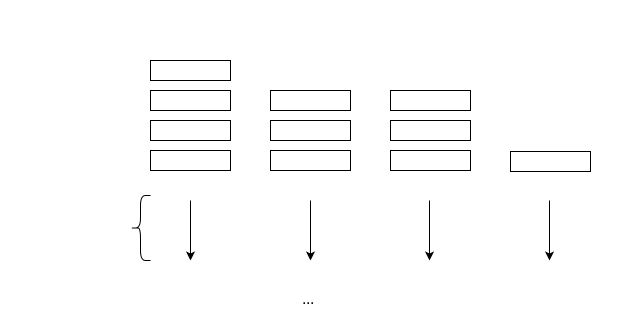

In [2]:
SVG("fairness_scenario.svg")

## Alle-mit-Allen Vergleich

Als Kostenfunktion wählen wir:

\begin{equation}
\underset{v}{\mathrm{min}} -\frac{1}{s_1} v_{1} - \frac{1}{s_2} v_{2} - \dots = -\sum_i \frac{1}{s_i} v_{i}
\end{equation}
Mit den gegebenen Parametern $s_i$. Diese Kostenfunktion spiegelt wieder, dass wir zunächst den Wert von $v_i$ maximieren wollen, für den $s_i$ am kleinsten ist. In der Implementierung schreiben wir tatsächlich 
$$
\frac{1}{\mathrm{max}(s_i,1)} v_{i}
$$
um zu verhindern, dass durch null geteilt wird. Die Kostenfunktion allein kann aber noch keine Fairness herstellen. Sollte beispielsweise $s_4$ kleiner als alle weitere Queues sein aber immer noch größer als $v_{max}$, würde ausschließlich aus dieser Queue gesendet werden.
Wir brauchen also noch die folgenden Beschränkungen:

\begin{equation}
(s_i-s_j)\cdot(v_j-v_i)\leq 0
\label{eq:cons_wo_limit}
\end{equation}

Wenn also z.B. $s_4$ größer ist als $s_3$, dann muss auch $v_4$ mindestens so groß wie $v_3$ sein (obwohl im Sinne des Optimierung zunächst $v_3$ erhöht werden soll.

** Update:**

Wir wollen zusätzlich berücksichtigen können, dass wir individuelle Beschränkungen für $v_i$ haben, in der Form:

\begin{equation}
v_i \leq v_{i,\mathrm{max}}
\end{equation}

Wenn für das oben beschriebene Szenario mit $v_3$ und $v_4$ eine Beschränkung für (e.g.) $v_4\leq 2$ existiert, soll $v_3$ wieder unbeschränkt zunehmen können. Wir können dies erreichen, indem wir \eqref{eq:cons_wo_limit} ergänzen:

\begin{equation}
(v_{i,\mathrm{max}}-v_i)\cdot (v_{j,\mathrm{max}}-v_j)(s_i-s_j)\cdot(v_j-v_i)\leq 0
\end{equation}


### Beispielrechnung

In [7]:
def fairness_all_vs_all(n):
    # Optimization variables:
    v = MX.sym('v',n)

    # Parameters:
    param = struct_symMX([
        entry('s', shape=(n)),
        entry('v_max_total'),
        entry('v_max', shape=(n))
    ])

    s = param['s']
    v_max_total = param['v_max_total']
    v_max = param['v_max']

    obj = sum1(-1/fmax(s,1)*v)

    cons = [] # All constraints are implemented such that cons[i]<=0.

    cons.append(sum1(v)-v_max_total)

    for i in range(n):
        # v[i]<s[i]
        cons.append(
            v[i]-s[i]
        )
        # v[i]>0
        cons.append(
            -v[i]
        )
        # Fairness constraint (with individual limits)
        for j in range(n):
            cons.append(
                (v_max[j]-v[j])*(v_max[i]-v[i])*(s[i]-s[j])*(v[j]-v[i])            
            )

    nlp = {'x':v, 'f':obj, 'g':vertcat(*cons), 'p':param}
    S = nlpsol('S', 'ipopt', nlp)
    return S, param

In [8]:
n = 4
S_fairness_all_vs_all, param = fairness_all_vs_all(n)

v_max_total = 8
s_num = np.array([4,2,1,7]) # Values from example above
v_max = np.array([1, 10, 10, 10])

param_num = param(0)
param_num['s'] = s_num
param_num['v_max_total'] = v_max_total
param_num['v_max'] = v_max

# Call for optimizer with initial guess (x0), lower bound for constraints as -Infinity and upper bound as 0.
# Parameters are passed in the same order as in the 'nlp' dictionary above.
r_all_vs_all = S_fairness_all_vs_all(x0=np.zeros(n),lbg=-np.inf, ubg=0,p=param_num)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.12, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:       36
Number of nonzeros in Lagrangian Hessian.............:       10

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equ

In [9]:
print(s_num)
print(r_all_vs_all['x'].full().flatten())

[4 2 1 7]
[1.         2.         1.00000001 3.99999998]


In [26]:
n=200
S_fairness_all_vs_all, param = fairness_all_vs_all(n)

v_max = 1000

s_num = np.round(50*np.random.rand(n))

ind_sort=np.argsort(s_num)

param_num = param(0)
param_num['s'] = s_num
param_num['v_max'] = v_max

In [33]:
r_all_vs_all = S_fairness_all_vs_all(x0=np.zeros(n),lbg=-np.inf, ubg=0,p=param_num)

This is Ipopt version 3.12.12, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:    80200
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      200
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:    40401
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:    40401

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

## Vergleich nach Sortierung

### Beispielrechnung

In [51]:
def fairness_sorted(n):
    # Optimization variables:
    v = MX.sym('v',n)

    # Parameters:
    param = struct_symMX([
        entry('s', shape=(n)),
        entry('v_max'),
        entry('P', shape=(n,n))
    ])

    s = param['s']
    P = param['P']
    v_max = param['v_max']

    v_sorted = P@v 

    obj = sum1(-1/fmax(s,1)*v)

    cons = [] # All constraints are implemented such that cons[i]<=0.

    cons.append(sum1(v)-v_max)

    for i in range(n):
        # v[i]<s[i]
        cons.append(
            v[i]-s[i]
        )
        # v[i]>0
        cons.append(
            -v[i]
        )
    # Fairness constraint:
    for i in range(n-1):
        cons.append(
            v_sorted[i]-v_sorted[i+1]
        )

    nlp = {'x':v, 'f':obj, 'g':vertcat(*cons), 'p':param}
    S = nlpsol('S', 'ipopt', nlp)
    return S, param

In [52]:
n = 4
S_fairness_sorted, param = fairness_sorted(n)

v_max = 7

s_num = np.array([4,3,3,3]) # Values from example above

ind_sort=np.argsort(s_num)
P=np.eye(n)
P=P[ind_sort,:]

param_num = param(0)
param_num['s'] = s_num
param_num['v_max'] = v_max
param_num['P'] = P

res_fairness_sorted = S_fairness_sorted(x0=np.zeros(n),lbg=-np.inf, ubg=0,p=param_num)

This is Ipopt version 3.12.12, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:       24
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        4
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       12
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       12

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

In [53]:
print(s_num)
print(res_fairness_sorted['x'].full().flatten())

[4 3 3 3]
[1.75000007 1.74999989 1.75       1.75000004]


### Für große Probleme

Anzahl der constraints sind nicht das Problem aber jetzt haben wir ```Number of nonzeros in inequality constraint Jacobian.:    40400```, da die Permutationsmatrizen ein unbekannte Sparsity Pattern haben. Im Resultat dauert die Optimierung unfassbar lang. Das Problem neu aufbauen wäre im konkreten Fall deutlich schneller.

In [29]:
n=200
S_fairness_sorted, param = fairness_sorted(n)

v_max = 1000

s_num = np.round(50*np.random.rand(n))

ind_sort=np.argsort(s_num)
P=np.eye(n)
P=P[ind_sort,:]

param_num = param(0)
param_num['s'] = s_num
param_num['v_max'] = v_max
param_num['P'] = P

In [30]:
res_fairness_sorted = S_fairness_sorted(x0=np.zeros(n),lbg=-np.inf, ubg=0,p=param_num)

This is Ipopt version 3.12.12, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:    40400
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      200
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      600
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      600

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

In [31]:
print(s_num)
print(np.round(res_fairness_sorted['x'].full().flatten()))

[46. 27. 50. 31. 46. 39. 47.  6.  6. 18. 39. 32.  3. 16. 15. 30. 38. 29.
 11. 21. 25. 26. 21.  1. 26. 40. 28. 40. 25. 26.  4. 20. 48. 23. 20. 32.
 29. 13. 23. 45.  2. 17. 14. 41. 13. 17. 14. 22. 47. 37. 20. 18. 44. 39.
 26. 24. 14. 46. 46. 43. 37.  1.  7. 34. 36. 49. 44. 16. 45. 16. 12.  7.
 13. 35. 38. 29. 19. 44. 22. 25. 11. 13. 11. 14. 20. 46. 44. 42.  7. 17.
  6. 14.  4.  3. 45. 24. 17. 38. 21. 46. 47. 29.  4. 40. 46. 46. 24.  5.
 16. 26. 23. 37.  2. 49.  8. 32. 38. 33. 31. 19. 43. 45. 18. 17. 38. 45.
 10. 25. 23. 30.  8. 14. 18. 34. 16. 47. 32. 26. 32. 34. 42. 34. 13. 33.
 27. 32. 10. 11. 36.  9. 14. 36. 14. 22. 26. 43. 13.  6. 43. 31. 42. 27.
 24. 46.  8.  4. 47. 27. 16. 22. 18. 39. 21. 12. 41. 13.  2. 11. 32. 15.
 29.  5. 35. 48. 28. 16. 28. 13. 15. 48.  7. 11. 20.  7. 25. 14. 21. 40.
 17. 32.]
[5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 3. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 1.
 5. 5. 5. 5. 5. 5. 4. 5. 5. 5. 5. 5. 5. 5. 5. 5. 2. 5. 5. 5. 5. 5. 5. 5.
 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 5. 1